In [3]:
import numpy as np
import h5py
import scipy
import math
import random
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [14]:
data_ = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')
names = ['z','mtot','q','iota','psi','ra','dec','chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z','det','snr']
data = {}
for n in names:
    data.update({n: np.array(data_[n])[:100000]})
X = np.column_stack(list(data[l] for l in names[:13]))
y = data['det']
snr = data['snr']

# Classification

## Number of features
I want to check if I can use only some features instead of all of them. I use RandomForest classifier

In [15]:
def compute_RFC(components):
    if (len(components)==1):
        x_train=X_train[:,components].reshape(-1,1)
        x_test = X_test[:,components].reshape(-1,1)
    else:
        x_train=X_train[:,components]
        x_test=X_test[:,components]
        
    ranfor = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    ranfor.fit(x_train,y_train)
    y_pred = ranfor.predict(x_test)
    return completeness_contamination(y_pred, y_test)

In [16]:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

100%|███████████████████████████████████████████| 13/13 [00:30<00:00,  2.34s/it]


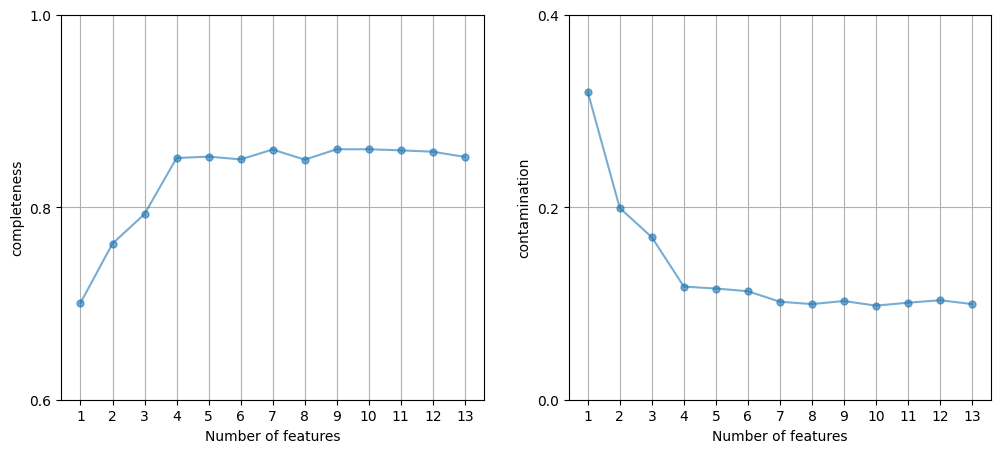

In [17]:
completeness = []
contamination = []
features=list(np.arange(i+1) for i in range(len(names)-2))
N_features = np.arange(0,len(names)-2)+1
for f in tqdm(features):
    com,con = compute_RFC(f)
    completeness.append(com)
    contamination.append(con)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.plot(N_features, completeness, '-o', ms=5,alpha=0.6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Number of features')
ax.set_ylabel('completeness')
ax.set_ylim(0.6, 1)
ax.grid(True)

ax = fig.add_subplot(122)
ax.plot(N_features, contamination, '-o', ms=5,alpha=0.6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('Number of features')
ax.set_ylabel('contamination')
ax.set_ylim(0, 0.4)
ax.grid(True)
plt.show()

Frome these plots I see that adding more features doesn't make the classifier performance increase much after N=4. That's why I decide use only the first 4 features ('z', 'mtot', 'q', 'iota'), in order to save computational time.

/tmp/ipykernel_140481/775074956.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(plt.cm.get_cmap('tab10')(i) for i in [4,9])


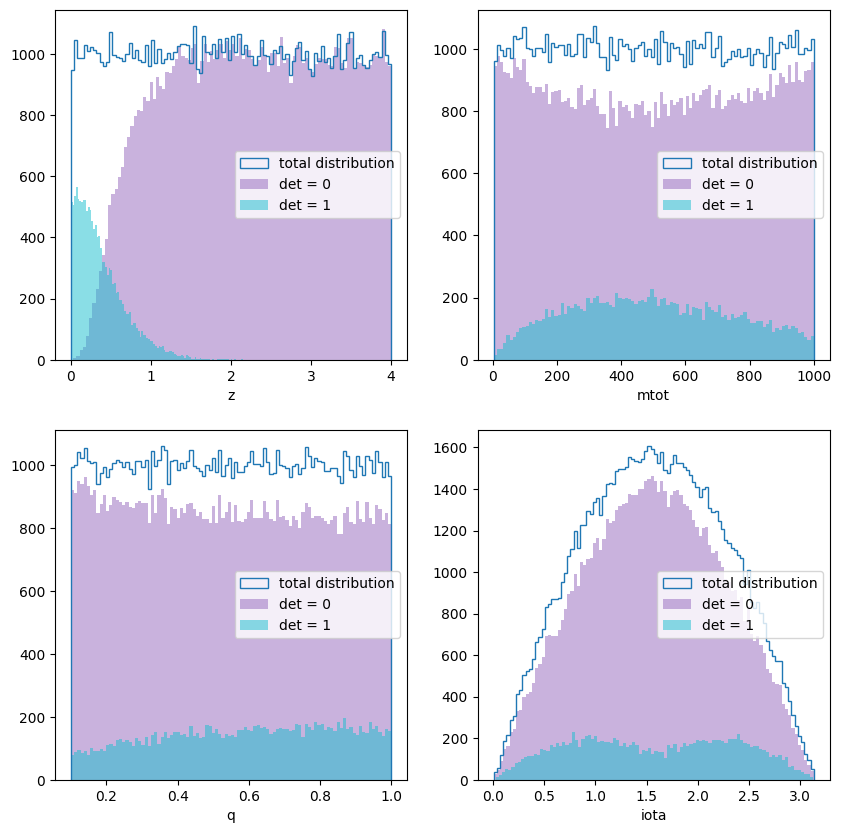

In [18]:
fig = plt.figure(figsize=(10, 10))
colors = list(plt.cm.get_cmap('tab10')(i) for i in [4,9])
for i,l in enumerate(names[:4]):
    ax=fig.add_subplot(2,2,1+i)
    ax.hist(X[:,i], histtype='step', bins=100, label='total distribution')
    ax.hist(X[:,i][y==0], bins=100, color=colors[0], alpha=0.5, label='det = 0')
    ax.hist(X[:,i][y==1], bins=100, color=colors[1], alpha=0.5, label='det = 1')
    ax.set_xlabel(l)
    ax.legend(loc='center right')
plt.show()

### Methods
I first try the simple DecisionTree, then I try Begging and RandomForest to control that their performance is better. I also try KNeighbors to compare the results with generative classification.

In [19]:
def find_best_RFC(X_train,y_train): 
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    drange = np.arange(5,15)  
    grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5)
    grid.fit(X_train, y_train)
    best = grid.best_params_['max_depth']
    return best

def find_best_KNN(X_train,y_train):
    clf = KNeighborsClassifier()
    nrange = np.arange(1,20) 
    grid = GridSearchCV(clf, param_grid={'n_neighbors': nrange}, cv=5)
    grid.fit(X_train, y_train)
    return grid.best_params_['n_neighbors']

def compute_models_comb(combinations,*args):
    classifiers = []
    predictions = []
    for classifier, kwargs in tqdm(args):
        classifiers.append([])
        predictions.append([])
        for comb in combinations:
            clf = classifier(**kwargs)
            clf.fit(X_train[:,comb], y_train)
            y_pred = clf.predict(X_test[:,comb])
            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)
    
    return classifiers, predictions

In [20]:
best_RFC = find_best_RFC(X_train[:,:],y_train)

In [21]:
best_KNN = find_best_KNN(X_train[:,:],y_train)

In [22]:
best_f = features[3]
methods = ['DecisionTree','Bagging','RandomForest','KNeighbors']
classifiers, predictions = compute_models_comb([best_f],
                                               (DecisionTreeClassifier, dict(random_state=0)),
                                               (BaggingClassifier, dict(estimator=DecisionTreeClassifier(random_state=0),
                                                                        n_estimators=100, max_samples=0.2,
                                                                        bootstrap=True, random_state=0, n_jobs=-1)),
                                               (RandomForestClassifier, dict(n_estimators=100, 
                                                                            max_depth=best_RFC, random_state=0, n_jobs=-1)),
                                              (KNeighborsClassifier, dict(n_neighbors=best_KNN)) )
completeness, contamination = completeness_contamination(predictions, y_test)
print("Completeness:\n")
for i,name in enumerate(methods):
    print(name,':', completeness[i].item())
    
print("\nContamination:\n")
for i,name in enumerate(methods):
    print(name,':', contamination[i].item())
    
print("\nAccuracy:\n")
for i,name in enumerate(methods):
    print(name,':', accuracy_score(predictions[i][0],y_test))

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]

Completeness:

DecisionTree : 0.8252840909090909
Bagging : 0.8482954545454545
RandomForest : 0.8556818181818182
KNeighbors : 0.7210227272727273

Contamination:

DecisionTree : 0.18854748603351956
Bagging : 0.10759115361625822
RandomForest : 0.11359623307828134
KNeighbors : 0.1991164405175134

Accuracy:

DecisionTree : 0.9484
Bagging : 0.96424
RandomForest : 0.96424
KNeighbors : 0.93548


Begging and RandomForest have higher completeness and lower contaminations as expected, but on the other hand KNeighbours's performance is worse, which means that generative classification is not the best choice for this problem

## PCA

Instead of focusing only on the first 4 features I can use PCA to reduce the dimensionality of the data set

In [23]:
from sklearn.decomposition import PCA

def compute_RFC_PCA(n):
    pca = PCA(n_components=n)
    pca.fit(X) # Do the fitting
    X_red = pca.transform(X)
    if (n==1):
        X_red = X_red.reshape(-1,1)
        
    (X_train, X_test), (y_train, y_test) = split_samples(X_red, y, [0.75, 0.25], random_state=0)
        
    ranfor = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    ranfor.fit(X_train,y_train)
    y_pred = ranfor.predict(X_test)
    return completeness_contamination(y_pred, y_test)

def compute_models_comb_PCA(X_train,y_train,X_test,*args):
    
    classifiers = []
    predictions = []
    for classifier, kwargs in tqdm(args):
        classifiers.append([])
        predictions.append([])
        
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)
    
    return classifiers, predictions


100%|█████████████████████████████████████████████| 8/8 [00:46<00:00,  5.77s/it]


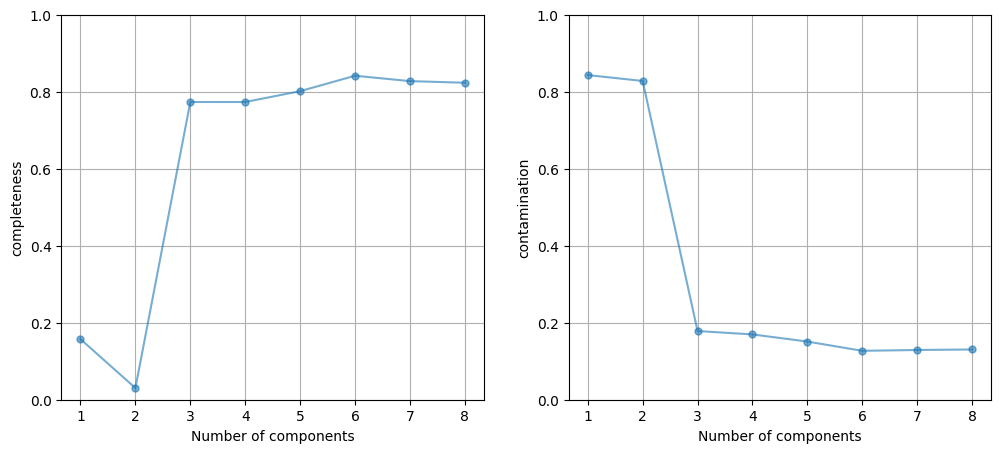

In [24]:
completeness = []
contamination = []
dimrange = np.arange(1,9)
for n in tqdm(dimrange):
    com,con = compute_RFC_PCA(n)
    completeness.append(com)
    contamination.append(con)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.plot(dimrange, completeness, '-o', ms=5,alpha=0.6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Number of components')
ax.set_ylabel('completeness')
ax.set_ylim(0, 1)
ax.grid(True)

ax = fig.add_subplot(122)
ax.plot(dimrange, contamination, '-o', ms=5,alpha=0.6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('Number of components')
ax.set_ylabel('contamination')
ax.set_ylim(0, 1)
ax.grid(True)
plt.show()

I choose 6 as the best number of components, since it has the highest completeness and the lowest contamination

In [25]:
pca = PCA(n_components=6)
pca.fit(X)
X_red = pca.transform(X)
(X_train, X_test), (y_train, y_test) = split_samples(X_red, y, [0.75, 0.25], random_state=0)

methods = ['DecisionTree','Begging','RandomForest','KNeighbors']
best_RFC = find_best_RFC(X_train[:,:],y_train)
best_KNN = find_best_KNN(X_train[:,:],y_train)
classifiers, predictions = compute_models_comb_PCA(X_train, y_train,X_test,
                                               (DecisionTreeClassifier, dict(random_state=0)),
                                               (BaggingClassifier, dict(estimator=DecisionTreeClassifier(random_state=0),
                                                                        n_estimators=100, max_samples=0.2,
                                                                        bootstrap=True, random_state=0, n_jobs=-1)),
                                               (RandomForestClassifier, dict(n_estimators=100, 
                                                                            max_depth=best_RFC, random_state=0, n_jobs=-1)),
                                              (KNeighborsClassifier, dict(n_neighbors=best_KNN)) )

completeness, contamination = completeness_contamination(predictions, y_test)
print("Completeness:\n")
for i,name in enumerate(methods):
    print(name,':', completeness[i].item())
    
print("\nContamination:\n")
for i,name in enumerate(methods):
    print(name,':', contamination[i].item())
    
print("\nAccuracy:\n")
for i,name in enumerate(methods):
    print(name,':', accuracy_score(predictions[i][0],y_test))

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.45s/it]

Completeness:

DecisionTree : 0.803409090909091
Begging : 0.8332386363636364
RandomForest : 0.8122159090909091
KNeighbors : 0.47301136363636365

Contamination:

DecisionTree : 0.20561797752808988
Begging : 0.13378617838157117
RandomForest : 0.1333737496210973
KNeighbors : 0.31396786155747836

Accuracy:

DecisionTree : 0.94304
Begging : 0.9584
RandomForest : 0.95596
KNeighbors : 0.89532


Using PCA with 6 components the performance of the classification is slightly worse

## Regression

I try to run the Gaussian Process Regressor on the values of SNR, after doing a CV test to set the Kernel parameters

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
(X_train, X_test), (snr_train, snr_test) = split_samples(X_scaled[:1200], snr[:1200], [0.75, 0.25], random_state=0)

x = X_train[:,:4]
y = snr_train
x_test = X_test[:,:4]
y_test =snr_test
det_test = (y_test > 12).astype(int)

cost = np.geomspace(1e2,1e5,3)
lenght = np.geomspace(1e-6,1e-1,3)
par = np.array(np.meshgrid(cost, lenght)).T.reshape(-1,2)
ind = np.arange(len(x),dtype=int)

np.random.seed(0)
cv_err = np.zeros(len(par))
np.random.shuffle(ind)
train = np.split(ind,4)

for i in tqdm(range(len(par))):
    cv_dist=np.array([])
    bounds=np.array([])
    for cv in train:
    
        x_cv=x[cv]
        y_cv=y[cv]

        x_train = np.delete(x,(cv),axis=0)
        y_train = np.delete(y,(cv),axis=0)
        bounds = np.array([par[i,:2]*1e-5,par[i,:2]*1e5])
        kernel = ConstantKernel(par[i,0],bounds[:,0])*RBF(par[i,1],bounds[:,1])
        
        gp = GaussianProcessRegressor(kernel=kernel, random_state=1)
        gp.fit(x_train, y_train)
        dist = np.sum((gp.predict(x_cv) - y_cv)**2)
        cv_dist = np.append(cv_dist,dist)
        
    cv_err[i] = np.sqrt(np.sum(cv_dist)/(4*len(y_cv)))

par_best=np.exp(gp.kernel_.theta)
b_best = np.exp(gp.kernel_.bounds)
kernel = ConstantKernel(par_best[0],b_best[0])*RBF(par_best[1],b_best[1])
gp = GaussianProcessRegressor(kernel=kernel, random_state=1)
gp.fit(x, y)

print('Best-fit kernel: ', gp.kernel_)

x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = gp.predict(x_test)

det_pred = (y_pred > 12).astype(int)
  
print("\nAccuracy:\n")
print(accuracy_score(det_pred,det_test))

100%|█████████████████████████████████████████████| 9/9 [00:46<00:00,  5.16s/it]


Best-fit kernel:  113**2 * RBF(length_scale=0.224)

Accuracy:

0.8966666666666666
